In [275]:
import pandas as pd
import numpy as np
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import *
from collections import Counter

In [276]:
class HierarchicalClustering:
    def __init__(self, state: str):
        self.state = state
        self.ACs = []
        for ac_name in os.listdir('./ACs'):
            if state in ac_name:
                ac_i = pd.read_pickle('./ACs/'+ac_name)
                self.ACs.append(ac_i)
        self.n_rows = len(self.ACs[0])

    def get_X_Y(self, row: int) -> (pd.DataFrame, pd.DataFrame):
        data = []
        for AC in self.ACs:
            AC = pd.DataFrame(AC)
            data.append(AC.iloc[row,:].tolist())
        data = pd.DataFrame(data).reset_index(drop=True)
        X = data.iloc[:,1:]
        Y = data.iloc[:,0]
        
        return X, Y    
    
    def cluster(self, X: pd.DataFrame, Y: pd.Series, method='ward') -> (list, list):
        dendrogram = sch.dendrogram(sch.linkage(X, method=method), no_plot=False)
        
        leaves = dendrogram['leaves']
        leaves_color_list = dendrogram['leaves_color_list']
        color_counts = Counter(dendrogram['leaves_color_list'])
        
        n_leaves = len(leaves_color_list)
        
        anomaly_score = [0] * n_leaves
        for i, color in zip(leaves, leaves_color_list):
            anomaly_score[i] = 1 - (color_counts[color]/n_leaves)
            
        return anomaly_score, Y.astype(int).tolist()
    
    def cluster_all(self, do_score=False, method='ward') -> (list, list):
        
        anomaly_score, y = [], []
        
        for row in range(self.n_rows):
            X, Y = hc.get_X_Y(row)
            if sum(Y) > len(Y)//2: continue
                
            anomaly_score_row, y_row  = hc.cluster(X,Y,method)
            
            anomaly_score += anomaly_score_row
            y += y_row
                    
        return anomaly_score, y
    
    def score(self, anomaly_score, y, threashold):
        
        yhat = [ 0 if y_i < threashold else 1 for y_i in anomaly_score]
            
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y, yhat)
        print('Accuracy: %f' % accuracy)
        # precision tp / (tp + fp)
        precision = precision_score(y, yhat)
        print('Precision: %f' % precision)
        # recall: tp / (tp + fn)
        recall = recall_score(y, yhat)
        print('Recall: %f' % recall)
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y, yhat)
        print('F1 score: %f' % f1)
        # AUC
        fpr, tpr, thresholds = roc_curve(y, anomaly_score)
        AUC = auc(fpr, tpr)
        print('AUC score: %f' % AUC)
        return yhat, y, anomaly_score
        

KeyboardInterrupt: 

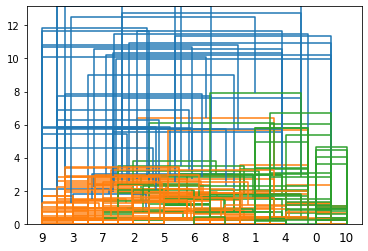

In [274]:
hc = HierarchicalClustering('harmonic_low_18_cold_fullyOpen')
anomaly_score, y = hc.cluster_all()

In [ ]:
for threashold in [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]:
    print('Threashold : ' + str(threashold))
    hc.score(anomaly_score, y, threashold)
    print('--------------------')